In [78]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import psycopg2
#import sqlalchemy as sa
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [79]:
#pulling in data from EW database and writing to file only need to run this once
#TODO: see if i can get PP TOI and Shooting Percentages and add in some stuff on sh% regressions
#engine = sa.create_engine(os.environ["EW_CONNECT"])

sql = """
select 
    player
    ,player_upper
    ,api_id::integer
    ,birthday
    ,season_age
    ,position
    ,position_type
    ,shoots
    ,team
    ,season
    ,session
    ,gp
    ,toi
    ,toi_gp
    ,toi_perc
    ,g
    ,a1
    ,a2
    ,points
from skater_std_sum_all
where session = 'R'
"""
#nhl_df = pd.read_sql(sql, engine)
#nhl_df.to_csv('player_goal_data.csv')

In [80]:
nhl_df = pd.read_csv('player_goal_data.csv')
#convert season to integers
nhl_df.season = nhl_df.season.astype(int)
#create a column to join on to get the next season
nhl_df['season_minus_one'] = nhl_df['season'] - 10001
nhl_df = nhl_df.groupby(['player', 'api_id', 'season', 'season_minus_one', 
                         'position_type', 'season_age'])[['g', 'a1', 'a2', 'points', 'toi', 'gp']].sum().reset_index()

In [81]:
#create dataframe of season to season goal correlation
new_df = nhl_df[['player', 'api_id', 'g', 'season', 'a1', 'a2', 'points', 'toi', 'gp',
                 'season_minus_one', 'position_type', 'season_age']].merge(
        nhl_df[['player', 'api_id', 'g', 'season', 'season_minus_one', 'position_type', 'season_age']], how='inner',
        left_on=['api_id', 'season'], right_on=['api_id', 'season_minus_one'])

new_df = new_df[new_df.gp >= 70]

In [82]:
#Now start building a new linear model that takes into affect new features and maybe use 
#ridge or lasso for feature selection. Also doing a bagging regressor with this too
#TODO: need to do some better feature/parameter creation i bet
#features:
#1.Season being predicted (dummy_variable) done
#2. player age done
#3. season # in the league (dummy variable)
#4. position (dummy variable) done
#5. toi_gp done
#6. previous years goals done
#7. previous years a1 done
#8. previous years a2 done
#9. previous years points done
#10. Past average of past two years goals
#season dummy variables
new_df = pd.concat([new_df, pd.get_dummies(new_df['season_y'], prefix='season')], axis=1)
#position dummy variable
new_df = pd.concat([new_df, pd.get_dummies(new_df['position_type_x'], prefix='pos')], axis=1)
#toi_gp
new_df['toi_gp'] = round(new_df['toi']/new_df['gp'], 2)

#create dataframe for forwards only
forwards_df = new_df[new_df.position_type_x == 'F']
#create dataframe for defense only
defense_df = new_df[new_df.position_type_x == 'D']

In [83]:
new_df.columns

Index(['player_x', 'api_id', 'g_x', 'season_x', 'a1', 'a2', 'points', 'toi',
       'gp', 'season_minus_one_x', 'position_type_x', 'season_age_x',
       'player_y', 'g_y', 'season_y', 'season_minus_one_y', 'position_type_y',
       'season_age_y', 'season_20082009', 'season_20092010', 'season_20102011',
       'season_20112012', 'season_20122013', 'season_20142015',
       'season_20152016', 'season_20162017', 'season_20172018',
       'season_20182019', 'season_20192020', 'pos_D', 'pos_D/F', 'pos_F',
       'toi_gp'],
      dtype='object')

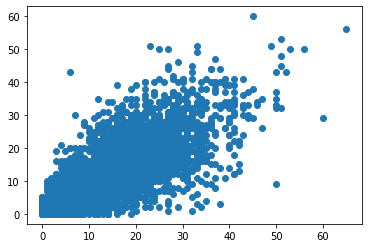

In [84]:
#total scatter correlation
#this is the test of linearity
plt.scatter(new_df[['g_x']], new_df[['g_y']])

In [85]:
#pearson correlation coefficients
forward_corr = forwards_df['g_x'].corr(forwards_df['g_y'])
def_corr = defense_df['g_x'].corr(defense_df['g_y'])
total_corr = new_df['g_x'].corr(new_df['g_y'])
print((f"Foward pearson R: {round(forward_corr, 2)}\n"
       f"Defense pearson R: {round(def_corr, 2)}\n"
       f"All Position Pearson R: {round(total_corr, 2)}"))

Foward pearson R: 0.65
Defense pearson R: 0.63
All Position Pearson R: 0.74


In [86]:
#create a baseline linear model using previous season goals to predict next season
#goals

from sklearn.model_selection import train_test_split

#create test and train dataframes
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=8675309)



(array([406., 532., 438., 405., 537., 310., 281., 217., 212., 114.,  72.,
         37.,  43.,  14.,   4.,  11.,   2.,   1.,   1.,   1.]),
 array([ 0.  ,  3.25,  6.5 ,  9.75, 13.  , 16.25, 19.5 , 22.75, 26.  ,
        29.25, 32.5 , 35.75, 39.  , 42.25, 45.5 , 48.75, 52.  , 55.25,
        58.5 , 61.75, 65.  ]),
 <BarContainer object of 20 artists>)

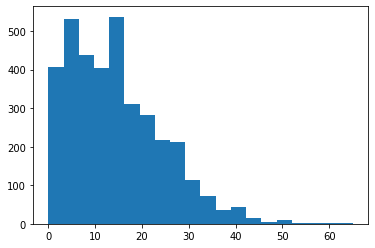

In [87]:
#Distribution of the data fits a poisson or pareto distribution
#this may be useful for more advanced models
plt.hist(new_df.g_x, bins=20)

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_estimators = 5000
reg = BaggingRegressor(LinearRegression(), n_estimators=n_estimators, bootstrap=True)

reg.fit(train_df[['g_x']], train_df[['g_y']].values[:,0])

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5000)

In [89]:
#This is bootstrapping a confidence interval for the results of linear regresssions
def bootstrap_prediction(bag_reg: BaggingRegressor, value: int):
    results = []
    for m in bag_reg.estimators_:
        results.append(m.predict(np.array([[value]]))[0])
    return results

(array([  1.,   9.,  14.,  45.,  76., 176., 321., 480., 599., 638., 708.,
        617., 510., 330., 222., 140.,  77.,  26.,   6.,   5.]),
 array([8.56247978, 8.59875578, 8.63503179, 8.6713078 , 8.7075838 ,
        8.74385981, 8.78013582, 8.81641182, 8.85268783, 8.88896384,
        8.92523984, 8.96151585, 8.99779186, 9.03406786, 9.07034387,
        9.10661988, 9.14289588, 9.17917189, 9.2154479 , 9.2517239 ,
        9.28799991]),
 <BarContainer object of 20 artists>)

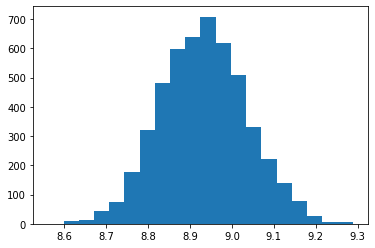

In [90]:
results = bootstrap_prediction(reg, 10)
plt.hist(results, bins=20)

In [91]:
import math
pd.options.mode.chained_assignment = None 
train_df[['y_hat']] = reg.predict(train_df[['g_x']])
#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = reg.score(train_df[['g_y']], train_df[['y_hat']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(train_df[['g_y']], train_df[['y_hat']])
print(("Baseline linear model train set metrics:\n"
       f"R^2 for train set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for train set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for train set: {round(math.sqrt(mse), 2)}"))

Baseline linear model train set metrics:
R^2 for train set: 0.4469
Mean Squared Error for train set: 40.8864
Root Mean Squared Error for train set: 6.39


In [92]:
test_df[['y_hat']] = reg.predict(test_df[['g_x']])
#Testing the coefficient of determination in the testing set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = reg.score(test_df[['g_y']], test_df[['y_hat']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(test_df[['g_y']], test_df[['y_hat']])
print(("Baseline linear model test set metrics:\n"
       f"R^2 for test set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for test set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for test set: {round(math.sqrt(mse), 2)}"))

Baseline linear model test set metrics:
R^2 for test set: 0.4171
Mean Squared Error for test set: 45.5186
Root Mean Squared Error for test set: 6.75


In [93]:
train_df.columns

Index(['player_x', 'api_id', 'g_x', 'season_x', 'a1', 'a2', 'points', 'toi',
       'gp', 'season_minus_one_x', 'position_type_x', 'season_age_x',
       'player_y', 'g_y', 'season_y', 'season_minus_one_y', 'position_type_y',
       'season_age_y', 'season_20082009', 'season_20092010', 'season_20102011',
       'season_20112012', 'season_20122013', 'season_20142015',
       'season_20152016', 'season_20162017', 'season_20172018',
       'season_20182019', 'season_20192020', 'pos_D', 'pos_D/F', 'pos_F',
       'toi_gp', 'y_hat'],
      dtype='object')

In [94]:
#Start training the model using more variables and compare to the baseline
n_estimators = 5000
multi_var_reg = BaggingRegressor(LinearRegression(), n_estimators=n_estimators, bootstrap=True)

multi_var_reg.fit(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], train_df[['g_y']].values[:,0])


BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5000)

In [95]:
import math
pd.options.mode.chained_assignment = None 
train_df[['y_hat_multi']] = multi_var_reg.predict(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']])


In [96]:
#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = multi_var_reg.score(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                          'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], train_df[['g_y']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(train_df[['g_y']], train_df[['y_hat_multi']])
print(("Baseline linear model train set metrics:\n"
       f"R^2 for train set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for train set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for train set: {round(math.sqrt(mse), 2)}"))

Baseline linear model train set metrics:
R^2 for train set: 0.5916
Mean Squared Error for train set: 37.2311
Root Mean Squared Error for train set: 6.1


In [97]:
from sklearn.metrics import mean_absolute_error
test_df[['y_hat_multi']] = multi_var_reg.predict(test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']])

#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = multi_var_reg.score(test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                          'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], test_df[['g_y']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(test_df[['g_y']], test_df[['y_hat_multi']])
print(("Baseline linear model test set metrics:\n"
       f"R^2 for test set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for test set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for test set: {round(math.sqrt(mse), 2)}\n"
       f"Mean Absolute Error for test set: "
       f"{round(mean_absolute_error(test_df[['g_y']], test_df[['y_hat_multi']]), 2)}"))

#This model does allright however i think it underates the ability of a player to score more goals the next season
#especially on outliers when those are usually the more talented players who would have a higher probability 
#of scoring at or more. I think there should be some probability in my distributions of prediction intervals
#to score more goals however slight Not sure how to get there yet. 2020-10-18

Baseline linear model test set metrics:
R^2 for test set: 0.579
Mean Squared Error for test set: 42.3895
Root Mean Squared Error for test set: 6.51
Mean Absolute Error for test set: 4.86


In [72]:
test_row = test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 'points', 
                    'season_y', 'pos_D', 'pos_D/F', 'pos_F']].loc[5359, :]

np.array([test_row])

array([[30., 13., 59.]])

In [73]:
results = []
for m in multi_var_reg.estimators_:
    results.append(m.predict([test_row]))

In [74]:
multi_var_reg.predict([test_row])

array([22.31486903])

In [75]:
results = [x[0] for x in results]

In [76]:
test_row

g_x       30.0
a2        13.0
points    59.0
Name: 5359, dtype: float64

(array([  1.,   4.,   4.,   9.,  27.,  68., 137., 272., 447., 659., 727.,
        756., 659., 501., 378., 193., 106.,  35.,  15.,   2.]),
 array([20.90087746, 21.02705963, 21.1532418 , 21.27942397, 21.40560614,
        21.5317883 , 21.65797047, 21.78415264, 21.91033481, 22.03651697,
        22.16269914, 22.28888131, 22.41506348, 22.54124564, 22.66742781,
        22.79360998, 22.91979215, 23.04597431, 23.17215648, 23.29833865,
        23.42452082]),
 <BarContainer object of 20 artists>)

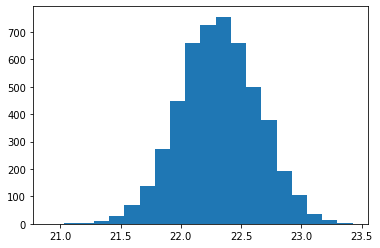

In [77]:
plt.hist(results, bins=20)


In [54]:
forty_df = new_df[new_df.g_x >= 30]

In [55]:
len(forty_df[forty_df.g_y >= 30].player_x.unique())/len(forty_df.player_x.unique())

0.38095238095238093

In [47]:
len(forty_df[forty_df.g_y >= 30].player_x.unique())

56

(array([ 1.,  4.,  1.,  1.,  3.,  6.,  3.,  8.,  4., 14.,  7.,  4.,  2.,
         2.,  1.,  1.,  3.,  1.,  1.,  1.]),
 array([ 9.  , 11.55, 14.1 , 16.65, 19.2 , 21.75, 24.3 , 26.85, 29.4 ,
        31.95, 34.5 , 37.05, 39.6 , 42.15, 44.7 , 47.25, 49.8 , 52.35,
        54.9 , 57.45, 60.  ]),
 <BarContainer object of 20 artists>)

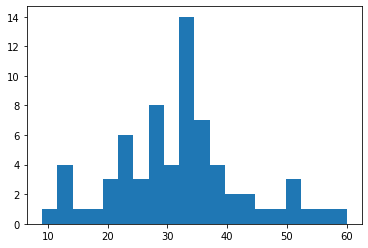

In [35]:
plt.hist(forty_df['g_y'], bins=20)

In [ ]:
#write a funciton to determine the pareto division of how much of the fat tail is held by what 
#percentage of players

In [216]:
#pareto distribution function
import math
alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
x_sub_m = 1
def pareto_prob(x):
    """
    returns probability that some number X will be greater than x by the distribution of the Pareto curve
    defined by observed goal scoring behavior
    """
    alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
    x_sub_m = 1
    return (x_sub_m/x)^alpha

In [65]:
total_seasons=new_df.shape[0]

In [66]:
more_goals_df = new_df[new_df.g_y > new_df.g_x]

In [67]:
seasons_w_more_goals = more_goals_df.shape

In [69]:
seasons_w_more_goals


(3571, 34)

In [70]:
seasons_w_more_goals[0]/total_seasons

0.41202261451482636

In [72]:
new_df.season_x.min()

20072008

In [73]:
f_more_goals = forwards_df[forwards_df.g_y > forwards_df.g_x].shape[0]
total_f_seasons = forwards_df.shape[0]
f_more_goals/total_f_seasons

0.42791842475386777